In [8]:
import pandas as pd
import numpy as np
import scipy.io
import re
import sys
import warnings
import pickle

For some reason, no matter what mask I use, I get the same predictive probability score. That's a red flag. Here, let's try using normalization to disrupt that.

In [1]:
import pickle
from IPython.core.display import display, HTML, Markdown

/tmp/ipykernel_16401/659417397.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [2]:
from mvpa2.datasets.mri import fmri_dataset

Failed to import duecredit due to No module named 'duecredit'
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):


In [3]:
class BehavioralDataNotFoundForBrainDataException(Exception):
    """Behavioral data could not be matched to a subject."""
    pass

In [4]:
from visualization import visualize_corr
import mvpa2

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/visualization.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [5]:
import sys
import os

sys.path.append(os.path.abspath("../../ml/"))


In [43]:
from nilearn.masking import unmask

## Load

In [6]:


nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [9]:
include_exclude_list = pd.read_csv("../nsc_subject_exclusions.csv")

In [10]:
test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20211027T173724.csv")
test_train_df_raw = test_train_df_raw.merge(include_exclude_list[include_exclude_list.Task=='SST'],left_on='sub_label',right_on='SubjectId',how='left')
test_train_df_raw.loc[test_train_df_raw.Include.isna(),'Include'] = True
test_train_df = test_train_df_raw[test_train_df_raw.Include==True]
exclude_subjects = ['DEV061','DEV185','DEV187','DEV189','DEV190','DEV192','DEV198','DEV203','DEV220','DEV221']
train_subjs = test_train_df.loc[test_train_df.SplitGroup=='Train','sub_label'].tolist()#only get the train subjects; ignore those previously marked hold-out

In [11]:
train_subjs_selected = [ts for ts in train_subjs if (ts not in exclude_subjects)]

In [12]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

We probably actually want to start the pipeline from the betas rather than loading from pickle. to be continued...

In [13]:
from mvpa_pipeline_utils import get_Brain_Data_betas_as_mvpa_for_sub, import_beta_series_pymvpa2, sa_to_df

## new code

In [14]:
from sklearn.model_selection import LeaveOneGroupOut

In [15]:
from sklearn.svm import LinearSVC
from scipy.stats import ttest_1samp, pearsonr

def pearson_img_series(img_series,img_cor):
    #iterate through the series
    img_length = img_series.shape[0]
    pearson_img_result = [0]*img_length
    
    for img_i in range(img_length):
        #now get the similarity
        #print(Brain_Data_allsubs[img_i,].samples.flatten().shape)
        #print(linearSVC_results['classifier'].coef_.flatten().shape)
        pearson_result = pearsonr(
            img_series[img_i,].flatten(),
            img_cor.flatten()
        )
        #we need the positive and the negative image to do this correctly
        #we're just going to assume that the positive should come first, that the classifier
        pearson_img_result[img_i] = [-pearson_result[0],pearson_result[0]]
        #print(pearson_result[0])
        
    return(pearson_img_result)

def do_LinearSVC(train_X,train_y,test_X,test_y):
    sklearn_clf = LinearSVC(penalty='l2', max_iter=1e4)
    #same as v3, my nilearn learner integrated with nltools
    #https://nilearn.github.io/modules/generated/nilearn.decoding.Decoder.html
    
    #sklearn_clf = CalibratedClassifierCV(clf_svc)
    #train
    sklearn_clf.fit(train_X, train_y)

    #get the _probability_ we fall into each class
    #we'll use similarity/correlation here.
    predict_y_prob = pearson_img_series(test_X,sklearn_clf.coef_)#sklearn_clf.predict_proba(test_X)
    predict_y = sklearn_clf.predict(test_X)
    return(predict_y,predict_y_prob,sklearn_clf)


In [47]:
def do_SVC(train_X,train_y,test_X,test_y):
    sklearn_clf = SVC(probability=True)

    #create the classifier with a probability function
    #https://mmuratarat.github.io/2019-10-12/probabilistic-output-of-svm#:~:text=SVMs%20don't%20output%20probabilities,the%20output%20to%20class%20probabilities.&text=For%20many%20problems%2C%20it%20is,of%20certainty%20about%20the%20answer.
    #we don't need this I'm doing my own probability estimate
    #hmmm, is this why the model is performing so well? the tuning?
    #sklearn_clf = CalibratedClassifierCV(clf_svc)
    #train
    print(" X features:" + str(train_X.shape[1]),end=", ")
    sklearn_clf.fit(train_X, train_y)

    #get the _probability_ we fall into each class
    predict_y_prob = sklearn_clf.predict_proba(test_X)
    predict_y = sklearn_clf.predict(test_X)
    return(predict_y,predict_y_prob,sklearn_clf)


def do_forced_choice(dataset,normalization=None,get_predict_and_prob=None):
    if get_predict_and_prob is None:
        get_predict_and_prob = do_SVC
    logo=LeaveOneGroupOut()

    group_scores = {}
    sample_wise_results = []
    
    for train_index, test_index in logo.split(
        dataset.samples, dataset.sa.targets, dataset.sa.chunks):
        iteration_label = np.unique(dataset.sa.chunks[test_index])[0]

        #print(iteration_label, "; TRAIN:", len(train_index), " items; TEST:", test_index)
        print(".",end="",flush=True)

        #do train-test split
        train_X=dataset.samples[train_index]
        test_X = dataset.samples[test_index]
        train_y=dataset.sa.targets[train_index]
        test_y = dataset.sa.targets[test_index]
        #clf_svc = SVC()
        
        if normalization=="train_set_based":
            #get mean based on train set alone
            voxel_mean = np.mean(train_X,axis=0)
            voxel_sd = np.std(train_X,axis=0)
            #apply it to all.
            train_X=(train_X-voxel_mean)/voxel_sd
            test_X=(test_X-voxel_mean)/voxel_sd
            #print("normalizing")
        
        predict_y, y_class_match, sklearn_clf = get_predict_and_prob(train_X,train_y,test_X,test_y)
        
        
        #need to label the output of the probability as CorrectStop and CorrectGo based on the classnames
        #iterate through each class
        proba_dict = {}
        for i, cls in enumerate(sklearn_clf.classes_):
            proba_dict[cls] = [x[i] for x in y_class_match]
            
        class_0 = sklearn_clf.classes_[0]
        class_1 = sklearn_clf.classes_[1]

        #find out which one of the two images is most likely to be CorrectGo
        class_0_choice_index = np.argmax(proba_dict[class_0])
        #now put that into a vector
        forced_choice_predictions = [class_1]*2
        forced_choice_predictions[class_0_choice_index] = class_0
        accuracy_score = np.sum([pred==target for pred,target in zip(forced_choice_predictions,test_y)])/len(test_y)
        #can we do a sample-wise table?

        group_scores[iteration_label] = accuracy_score
        sample_wise_results_iter = pd.DataFrame({
            'chunks':[iteration_label]*len(test_y),
            'target_y':test_y,
            'pred_y':predict_y,
            'pred_y_forced_choice':forced_choice_predictions
        })
        #add the class-wise probabilities
        for cls in sklearn_clf.classes_:
            sample_wise_results_iter['pred_prob_' + cls] = proba_dict[cls]
            
        sample_wise_results = sample_wise_results + [sample_wise_results_iter]
        
    #need to create one more classifier to return.
    #we test and train on the same here, which is OK, because we don't use this to assess performance
    y_predict, y_class_match, clf_svc_final =get_predict_and_prob(
        dataset.samples,dataset.sa.targets,dataset.samples,dataset.sa.targets)
            
    sample_wise_results_df = pd.concat(sample_wise_results)
    return({'sample_wise':sample_wise_results_df,'group_wise':group_scores,'classifier':clf_svc_final})


In [17]:
def setup_metadata(bd,target_attri_label = 'condition_label', standardize=False):
    #set up chunks and targets so we can do the learning.
    attribute_df = sa_to_df(bd.sa)
    pd.concat([attribute_df['subject'],attribute_df['wave']],axis=1)
    chunk = attribute_df['subject']+"_" + attribute_df['wave'].astype(str)
    bd.sa['chunks'] = list(chunk)
    if standardize:
        target_data = bd.sa[target_attri_label].value
        target_data_mean = np.nanmean(target_data)
        target_data_std = np.nanstd(target_data)
        target_data_norm = (target_data-target_data_mean)/target_data_std
        bd.sa['targets'] = list(target_data_norm)
    else:
        bd.sa['targets'] = list(bd.sa[target_attri_label].value)

    return(bd)

In [18]:
def remove_selected_outliers_mvpa_tesq_study(
    ind_div_combined,
    show_plot=False,
    neural_measures = ['CorGo_ln_inv_pred_prob_CorrectGo','CorStop_ln_inv_pred_prob_CorrectStop']):
    idc_outliers_removed = remove_selected_outliers(ind_div_combined,
    ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies',
     'SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
     'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction',
     'TESQ_E_goal_and_rule_setting','TESQ_E_sum','EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look',
     'SRHI_unhealthy','cancer_promoting_minus_preventing_FFQ','bf_1'] + neural_measures,
    show_plot=show_plot)
    return(idc_outliers_removed)

In [19]:

import math
def inv_log_transform(series):
    series=series.copy()
    not_na_vals = np.isnan(series)==False
    log_vals = [math.log(1-x) for x in (series[not_na_vals])]
    series[not_na_vals] = log_vals
    return(log_vals)


In [20]:
from outlier_detection import *

def print_forced_choice_results(forced_choice_results, neural_measures = ['pred_prob_CorrectStop']):
    prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
    forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
    print((prediction, forced_choice_prediction))
    
    sample_wise_results = forced_choice_results['sample_wise']
    cs_cs_prob = sample_wise_results.loc[sample_wise_results.target_y=='CorrectStop']

    individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
    full_dataset_cs = individual_differences.merge(cs_cs_prob,how='outer',left_on='subj_wave',right_on='chunks')
    
    full_dataset_cs = remove_selected_outliers_mvpa_tesq_study(full_dataset_cs,neural_measures = neural_measures)
    
    #https://docs.google.com/presentation/d/10tKHw1VF2WiMapvKXkh2C9VeFHk6iCjTmc0tDTiugOk/edit#slide=id.g11512b79600_0_10
    for nm in neural_measures:
        visualize_corr(nm,'bf_1',full_dataset_cs)
        visualize_corr(nm,'cancer_promoting_minus_preventing_FFQ',full_dataset_cs)
        visualize_corr(nm,'TESQ_E_sum',full_dataset_cs)
    
    

    

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/outlier_detection.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


## whole brain

In [21]:
from sklearn.model_selection import LeaveOneGroupOut

In [22]:
from sklearn.svm import SVC
#from mvpa2.measures.base import CrossValidation
#from mvpa2.clfs.meta import NFoldPartitioner
#from mvpa2.clfs.svm import LinearCSVMC
from sklearn.calibration import CalibratedClassifierCV


Now let's scale that up to the full dataset.

In [23]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl'

In [24]:
results_filepath=ml_data_folderpath + "/SST/ttr_mvpa2_res_v5_conditions_84subs_twoclasses_wholebrain.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

relevant_mask = None

In [25]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)


In [26]:
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

In [27]:
print(os.path.exists(results_filepath))

True


In [28]:
if os.path.exists(results_filepath):
    with open(results_filepath, 'rb') as pkl_file:
        forced_choice_results = pickle.load(pkl_file)
else:
    forced_choice_results = do_forced_choice(Brain_Data_allsubs)
    with open(results_filepath, 'wb') as pkl_file:
        pickle.dump(forced_choice_results,file=pkl_file)

    

In [29]:
forced_choice_results['sample_wise']

,chunks,target_y,pred_y,pred_y_forced_choice,pred_prob_CorrectGo,pred_prob_CorrectStop
0,DEV005_1,CorrectGo,CorrectGo,CorrectGo,0.950488,0.049512
1,DEV005_1,CorrectStop,CorrectStop,CorrectStop,0.088201,0.911799
0,DEV006_1,CorrectGo,CorrectGo,CorrectGo,0.992946,0.007054
1,DEV006_1,CorrectStop,CorrectStop,CorrectStop,0.179542,0.820458
0,DEV010_1,CorrectGo,CorrectGo,CorrectGo,0.989892,0.010108
...,...,...,...,...,...,...
1,DEV216_1,CorrectStop,CorrectStop,CorrectStop,0.236497,0.763503
0,DEV217_1,CorrectGo,CorrectGo,CorrectGo,0.984806,0.015194
1,DEV217_1,CorrectStop,CorrectStop,CorrectStop,0.050841,0.949159
0,DEV218_1,CorrectGo,CorrectStop,CorrectGo,0.517527,0.482473


In [30]:
total_score = np.mean(list(forced_choice_results['group_wise'].values()))
total_score

0.9876543209876543

Alright--and how about if we don't do the forced-choice?

In [31]:
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

In [32]:
print(prediction)
print(forced_choice_prediction)

0.9506172839506173
0.9876543209876543


## masks

We get the same file this time, but we apply a mask before doing learning.

In [33]:
from generic_utils import *

In [34]:
## additional masks

all_masks = get_all_masks(ml_data_folderpath)

In [35]:
for mask_name in all_masks['mask_name']:
#    mask_value = all_masks[mask_name]
    print(mask_name,end=", ")

planning_association-test_z_FDR_0.01, executive function_association-test_z_FDR_0.01, response inhibition_association-test_z_FDR_0.01, inhibition_association-test_z_FDR_0.01, harvardoxford-cortical_prob_Frontal Orbital Cortex, harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis, harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis, 

## normalization...

In [39]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl'

In [40]:
results_filepath=ml_data_folderpath + "/SST/ttr_mvpa2_res_v3_conditions_84subs_twoclasses_wholebrain.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))


relevant_mask = None

### across series, training data only

In [41]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

    
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

In [48]:
Brain_Data_allsubs.samples.copy()

array([[ 0.7312383 ,  0.27183977, -0.09587598, ..., -0.9286324 ,
         0.68275356, -0.1660184 ],
       [-0.381091  , -0.41968623, -0.42312527, ..., -0.6829239 ,
        -0.12775972, -0.3424021 ],
       [-0.00422587, -0.6077599 , -0.9000941 , ..., -2.3298805 ,
        -0.33732155, -1.3221407 ],
       ...,
       [ 0.41749677,  0.32663387,  0.26954317, ...,  0.38780513,
        -0.2603853 ,  0.03476725],
       [ 0.25094506, -0.56350684, -1.2193519 , ...,  0.9981551 ,
         0.6138571 ,  0.8256795 ],
       [ 0.03494082, -0.22820817, -0.46821654, ..., -0.01853149,
        -0.21609281, -0.10853325]], dtype=float32)

In [61]:
print(np.mean(Brain_Data_allsubs.samples,axis=0))

[ 1.1773757e-08  0.0000000e+00 -7.3585982e-09 ... -1.1773757e-08
  6.6227386e-08  2.0604075e-08]


In [62]:
print(np.std(Brain_Data_allsubs.samples,axis=0))

[1.        1.0000001 1.        ... 1.        1.        0.9999999]


In [63]:
do_forced_choice(Brain_Data_allsubs,normalization="train_set_based")

.................................................................................

{'sample_wise':        chunk     target_y       pred_y pred_y_forced_choice  \
 0   DEV005_1    CorrectGo    CorrectGo            CorrectGo   
 1   DEV005_1  CorrectStop  CorrectStop          CorrectStop   
 0   DEV006_1    CorrectGo    CorrectGo            CorrectGo   
 1   DEV006_1  CorrectStop  CorrectStop          CorrectStop   
 0   DEV010_1    CorrectGo    CorrectGo            CorrectGo   
 ..       ...          ...          ...                  ...   
 1   DEV216_1  CorrectStop  CorrectStop          CorrectStop   
 0   DEV217_1    CorrectGo    CorrectGo            CorrectGo   
 1   DEV217_1  CorrectStop  CorrectStop          CorrectStop   
 0   DEV218_1    CorrectGo    CorrectGo            CorrectGo   
 1   DEV218_1  CorrectStop  CorrectStop          CorrectStop   
 
     pred_prob_CorrectGo  pred_prob_CorrectStop  
 0              0.928721               0.071279  
 1              0.148201               0.851799  
 0              0.974001               0.025999  
 1             

### across series, whole set

In [64]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

    
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

In [65]:
def bd_mean_across_images_per_voxel(bd):
    voxel_mean = np.mean(bd.samples,axis=0)
    voxel_sd = np.std(bd.samples,axis=0)
    bd.samples = (bd.samples-voxel_mean)/voxel_sd
    return(bd)

In [66]:
Brain_Data_allsubs = bd_mean_across_images_per_voxel(Brain_Data_allsubs)

In [69]:
norm_across_whole_set = do_forced_choice(Brain_Data_allsubs)

.................................................................................

In [90]:
def get_pred_fcp(x):
    prediction = np.mean(x['sample_wise']['target_y']==x['sample_wise']['pred_y'])
    forced_choice_prediction = np.mean(x['sample_wise']['target_y']==x['sample_wise']['pred_y_forced_choice'])
    return(prediction,forced_choice_prediction)

In [91]:
get_pred_fcp(norm_across_whole_set)

(0.9506172839506173, 0.9876543209876543)

## across each image

In [84]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

    
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

In [85]:
def bd_mean_across_voxels_per_img(bd):
    img_mean = np.mean(bd.samples,axis=1,keepdims=True)
    img_sd = np.std(bd.samples,axis=1,keepdims=True)
    bd.samples = (bd.samples-img_mean)/img_sd
    return(bd)

In [86]:
Brain_Data_allsubs = bd_mean_across_voxels_per_img(Brain_Data_allsubs)


In [87]:
norm_across_each_img = do_forced_choice(Brain_Data_allsubs)

.................................................................................

In [88]:
prediction = np.mean(norm_across_each_img['sample_wise']['target_y']==norm_across_each_img['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(norm_across_each_img['sample_wise']['target_y']==norm_across_each_img['sample_wise']['pred_y_forced_choice'])

In [89]:
prediction, forced_choice_prediction

(0.845679012345679, 0.9876543209876543)

## neural similarity

Previously we used neural similarity. this learner is actually more accurate, and what's more, we get a numeric probability which will be helpful.

Firstly, how can we re-eimplemnt the correlation I've already done?

Next to do:
1. Consider re-implementing LinearSVM and getting similarity rather than this probability measure
2. Visualize for all the other values.

Now we've decoupled the learner from the framework where we apply it, we can pass in any arbitrary learner. It just has to output:

1. predictions 
2. prediction confidence 
3. the classifier itself

## Apply the main analysis, looping through masks

planning_association-test_z_FDR_0.01
2705.6913580246915


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9320987654320988 0.9876543209876543
(0.9320987654320988, 0.9876543209876543)


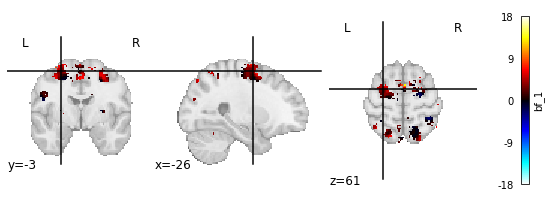

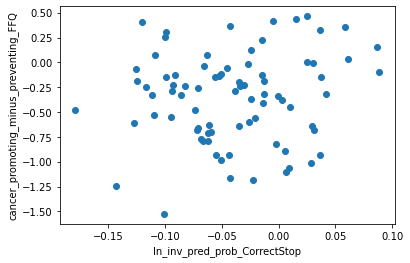

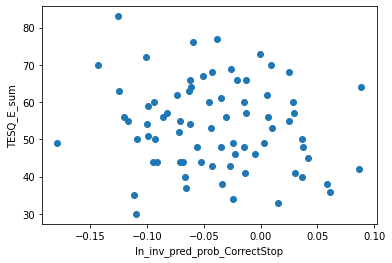

executive function_association-test_z_FDR_0.01
99.72839506172839


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9135802469135802 0.9753086419753086
(0.9135802469135802, 0.9753086419753086)


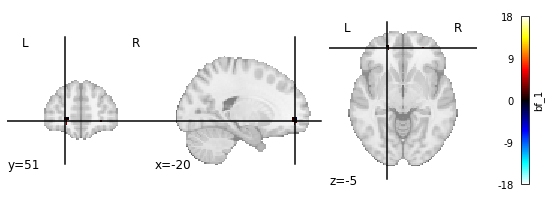

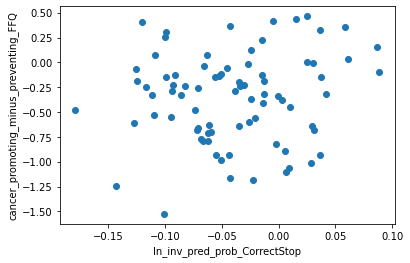

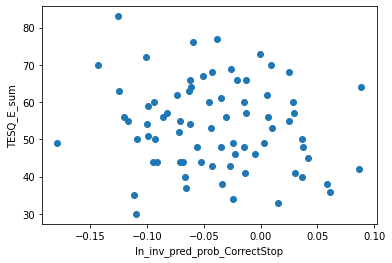

response inhibition_association-test_z_FDR_0.01
1958.111111111111


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9382716049382716 0.9753086419753086
(0.9382716049382716, 0.9753086419753086)


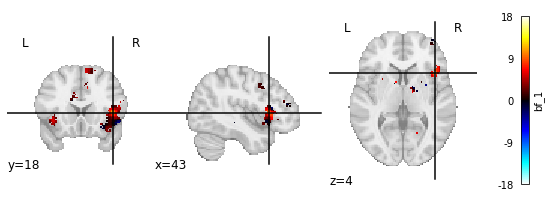

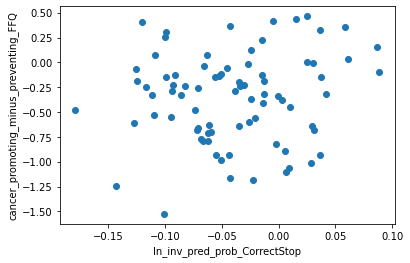

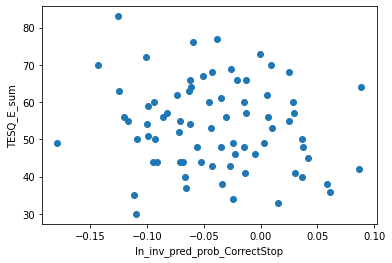

inhibition_association-test_z_FDR_0.01
667.4135802469136


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9259259259259259 0.9753086419753086
(0.9259259259259259, 0.9753086419753086)


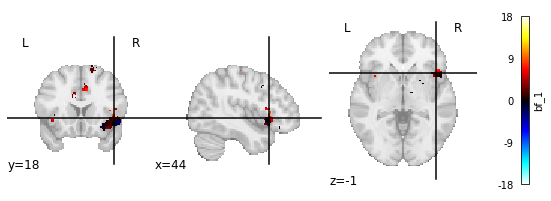

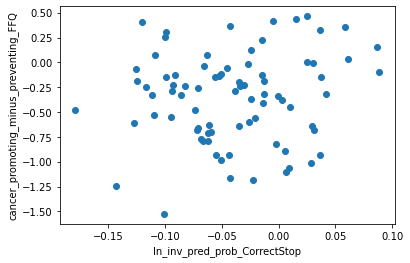

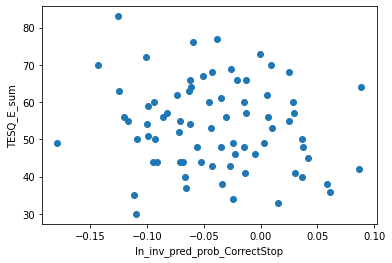

harvardoxford-cortical_prob_Frontal Orbital Cortex
3142.7654320987654


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9506172839506173 0.9753086419753086
(0.9506172839506173, 0.9753086419753086)


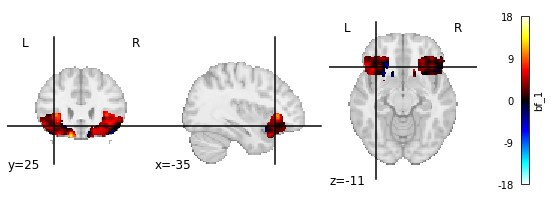

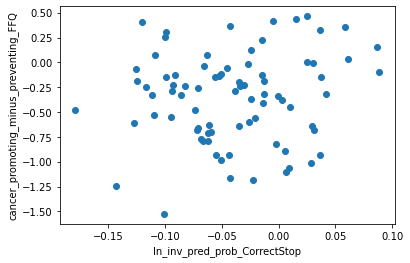

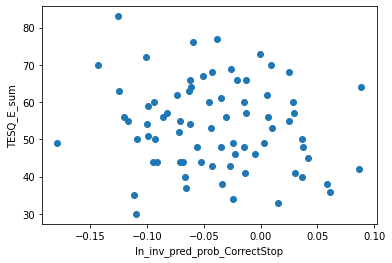

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
2416.91975308642


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9320987654320988 0.9753086419753086
(0.9320987654320988, 0.9753086419753086)


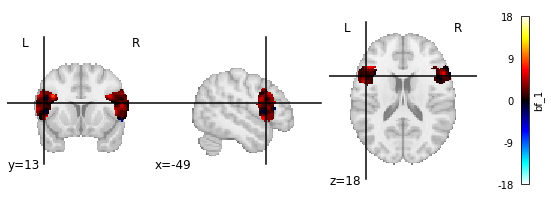

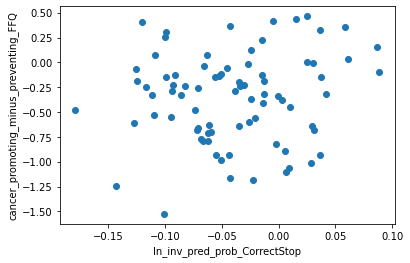

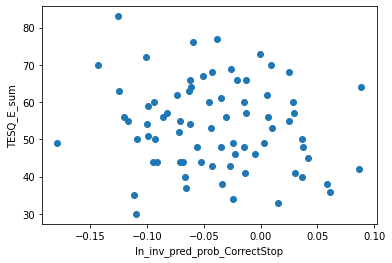

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
2102.1666666666665


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.9444444444444444 0.9753086419753086
(0.9444444444444444, 0.9753086419753086)


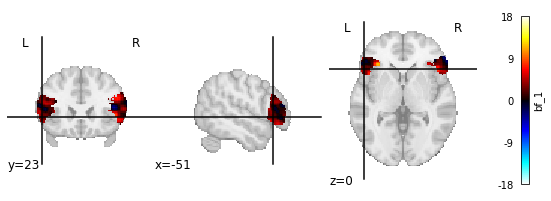

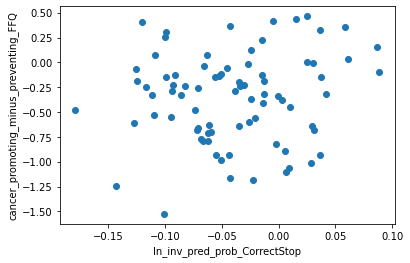

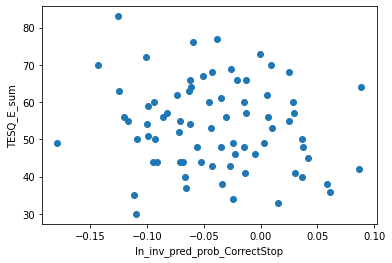

In [74]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])


        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        print_forced_choice_results(forced_choice_results,['ln_inv_pred_prob_CorrectStop'])

planning_association-test_z_FDR_0.01
2705.6913580246915


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


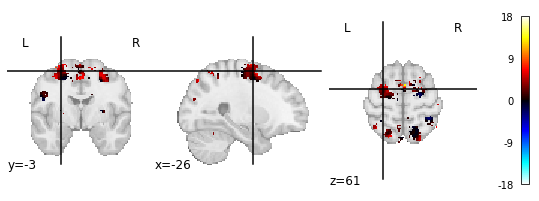

. X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features:4397, . X features

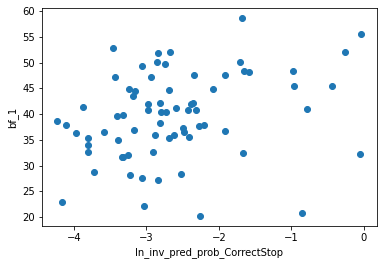

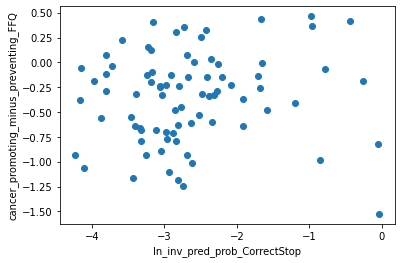

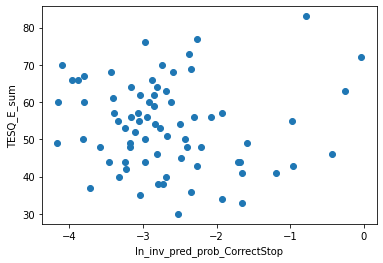

executive function_association-test_z_FDR_0.01
99.72839506172839


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


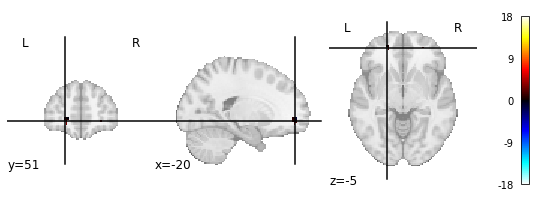

. X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X features:178, . X featur

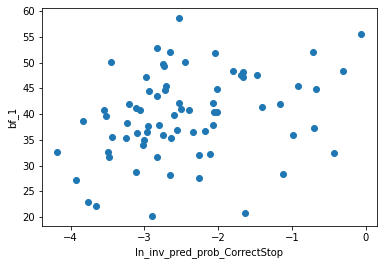

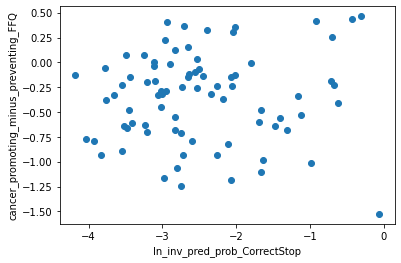

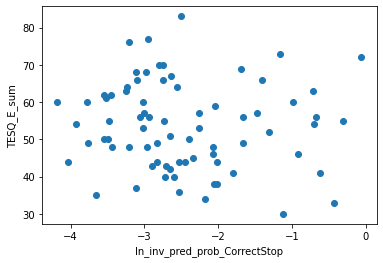

response inhibition_association-test_z_FDR_0.01
1958.111111111111


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


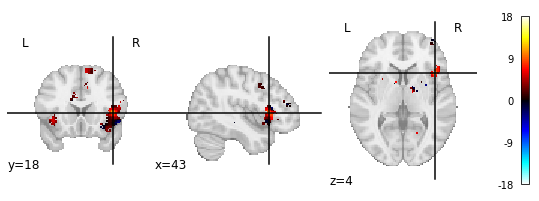

. X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features:2797, . X features

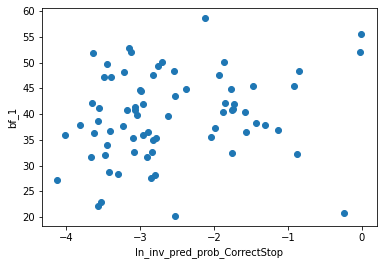

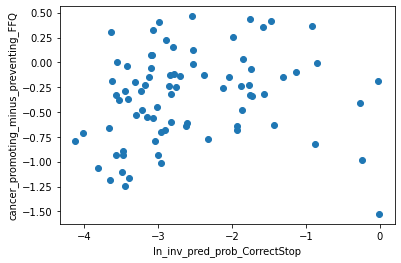

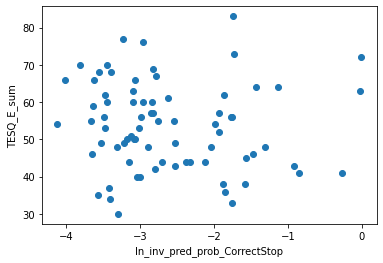

inhibition_association-test_z_FDR_0.01
667.4135802469136


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


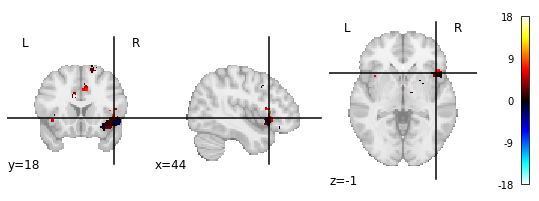

. X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X features:935, . X featur

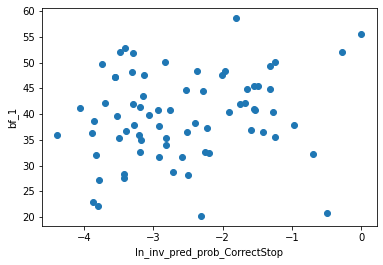

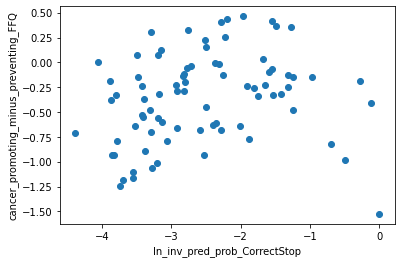

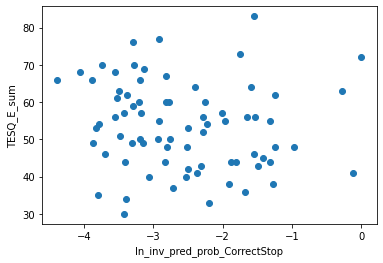

harvardoxford-cortical_prob_Frontal Orbital Cortex
3142.7654320987654


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


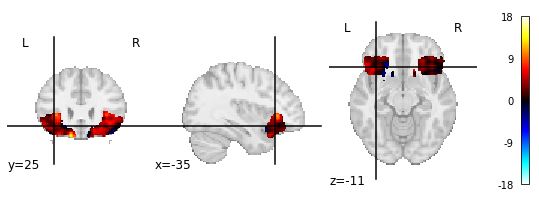

. X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features:5571, . X features

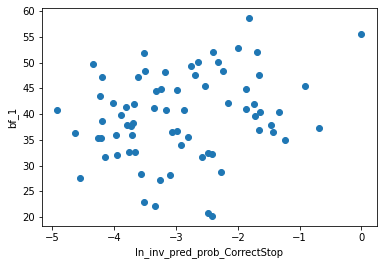

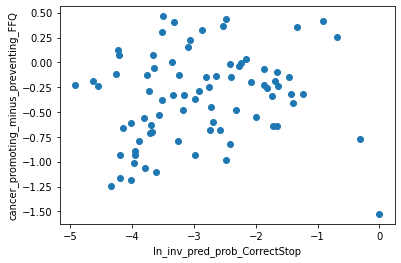

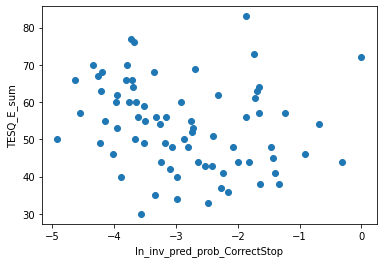

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
2416.91975308642


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


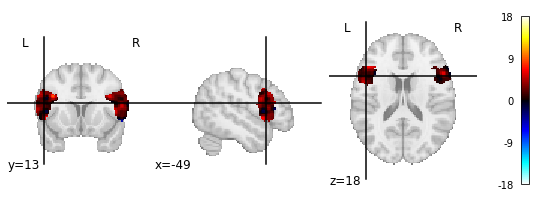

. X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features:3496, . X features

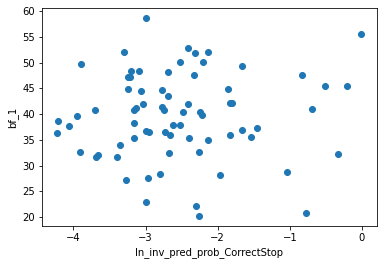

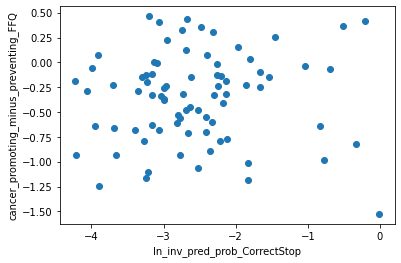

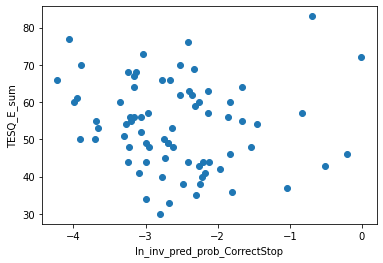

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
2102.1666666666665


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


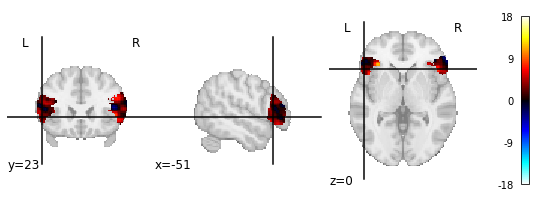

. X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features:3294, . X features

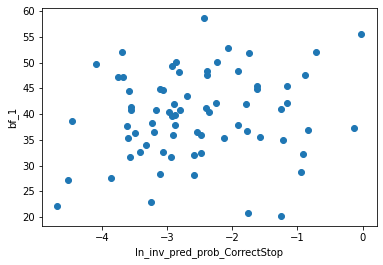

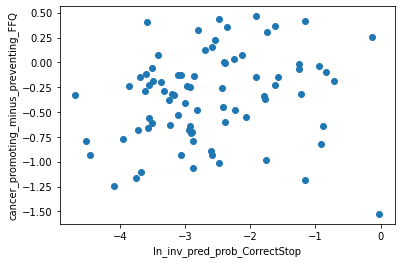

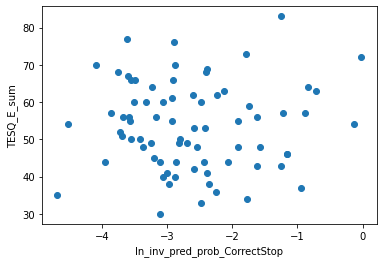

In [49]:
from outlier_detection import *

def print_forced_choice_results(fcr, neural_measures = ['pred_prob_CorrectStop']):
    prediction = np.mean(fcr['sample_wise']['target_y']==fcr['sample_wise']['pred_y'])
    forced_choice_prediction = np.mean(fcr['sample_wise']['target_y']==fcr['sample_wise']['pred_y_forced_choice'])
    print((prediction, forced_choice_prediction))
    
    sample_wise_results = fcr['sample_wise']
    cs_cs_prob = sample_wise_results.loc[sample_wise_results.target_y=='CorrectStop']

    individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
    full_dataset_cs = individual_differences.merge(cs_cs_prob,how='outer',left_on='subj_wave',right_on='chunks')
    
    full_dataset_cs = remove_selected_outliers_mvpa_tesq_study(full_dataset_cs,neural_measures = neural_measures)
    
    print(full_dataset_cs[neural_measures])
    #https://docs.google.com/presentation/d/10tKHw1VF2WiMapvKXkh2C9VeFHk6iCjTmc0tDTiugOk/edit#slide=id.g11512b79600_0_10
    for nm in neural_measures:
        visualize_corr(nm,'bf_1',full_dataset_cs)
        visualize_corr(nm,'cancer_promoting_minus_preventing_FFQ',full_dataset_cs)
        visualize_corr(nm,'TESQ_E_sum',full_dataset_cs)
    
    

    

forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)
        print("")
        
        sample_wise_results = forced_choice_results['sample_wise']
        
        prediction = np.mean(sample_wise_results['target_y']==sample_wise_results['pred_y'])
        forced_choice_prediction = np.mean(sample_wise_results['target_y']==sample_wise_results['pred_y_forced_choice'])
        
        sample_wise_results['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
        sample_wise_results['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])


        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        print_forced_choice_results(forced_choice_results,['ln_inv_pred_prob_CorrectStop'])

whole brain
127427.37037037036
.................................................................................0.9506172839506173 0.9876543209876543
(0.9506172839506173, 0.9876543209876543)


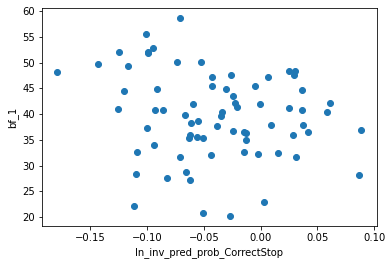

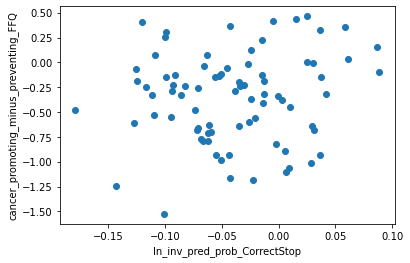

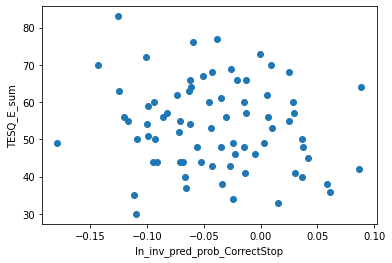

In [76]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)


prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])



print(prediction,forced_choice_prediction)

forced_choice_results_dict[mask_name]=forced_choice_results
print_forced_choice_results(forced_choice_results,['ln_inv_pred_prob_CorrectStop'])

OK. Having observed we always get teh same predictive probabilities regardless of the mask applied, theree's something really odd. Perhaps we ought to apply spatial normalization...
